# Music Generation Using LSTM Neural Network

## Real World Problem

This case-study focuses on generating music automatically using Recurrent Neural Network(RNN).<br> 
We do not necessarily have to be a music expert in order to generate music. Even a non expert can generate a decent quality music using RNN.<br>
We all like to listen interesting music and if there is some way to generate music automatically, particularly decent quality music then it's a big leap in the world of music industry.<br><br>
<b>Task:</b>There are many fields where Neural Networks are showing commendable grown with impeccable results matching humans in performance.  Some of them are Image Recognition, Speech recognition, speech to text conversion. In this work I want to explore Music Generation using Character based RNN, there are already many kinds of implementations about music generation. I want to explore one kind of music generation which is least explored by others and demonstrate my findings.
<br><br>
Now, what is music? In short music is nothing but a sequence of musical notes. My input to the model is a sequence of musical events/notes and output will be new sequence of musical events/notes. In this case-study I have limited myself to single instrument music as this is my first cut model. In future, I will try to extend this to multiple instrument music. 

## Data Source:
1. http://trillian.mit.edu/~jc/music/book/oneills/1850/X/


In [7]:
def read_batches(all_chars, unique_chars):
    length = all_chars.shape[0]
    batch_chars = int(length / BATCH_SIZE) 
    
    for start in range(0, batch_chars - SEQ_LENGTH, 64):  #it denotes number of batches. It runs everytime when
        #new batch is created.
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH))
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, unique_chars))
        for batch_index in range(0, 16):  #it denotes each row in a batch.  
            for i in range(0, 64):  #it denotes each column in a batch. Each column represents each character means 
                #each time-step character in a sequence.
                X[batch_index, i] = all_chars[batch_index * batch_chars + start + i]
                Y[batch_index, i, all_chars[batch_index * batch_chars + start + i + 1]] = 1 #here I have added '1' because the
                #correct label will be the next character in the sequence. So, the next character will be denoted by
                #all_chars[batch_index * batch_chars + start + i + 1]
        yield X, Y

In [4]:
import os
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import matplotlib.pyplot as plt
data_directory = "./Music-Generation-Using-Deep-Learning-master/Data/"
data_file = "Test_result.txt"
charIndex_json = "char_to_index.json"
model_weights_directory = './Music-Generation-Using-Deep-Learning-master/Data/Model_Weights_NoDropoutModifiedData/'
BATCH_SIZE = 16
SEQ_LENGTH = 64
epochs=100
file = open(os.path.join(data_directory, data_file), mode = 'r')
data = file.read()
file.close()

char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(data))))}
print("Number of unique characters in our whole tunes database = {}".format(len(char_to_index))) #95

with open(os.path.join(data_directory, charIndex_json), mode = "w") as f:
    json.dump(char_to_index, f)
    
index_to_char = {i: ch for (ch, i) in char_to_index.items()}
unique_chars = len(char_to_index)
#model creation    
model = Sequential()

model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (BATCH_SIZE, SEQ_LENGTH))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
#model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences = True, stateful = True))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(unique_chars)))

model.add(Activation("softmax"))
model.summary()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

all_characters = np.asarray([char_to_index[c] for c in data], dtype = np.int32)
print("Total number of characters = "+str(all_characters.shape[0])) #781989

epoch_number, loss, accuracy = [], [], []
max_checks_without_progress = 5
checks_without_progress = 0
best_loss = np.infty
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    final_epoch_loss, final_epoch_accuracy = 0, 0
    epoch_number.append(epoch+1)
    
    for i, (x, y) in enumerate(read_batches(all_characters, unique_chars)):
        final_epoch_loss, final_epoch_accuracy = model.train_on_batch(x, y) 
    loss.append(final_epoch_loss)
    accuracy.append(final_epoch_accuracy)
    print("Loss: {}, Accuracy: {}".format(final_epoch_loss, final_epoch_accuracy))
    if loss[epoch] < best_loss:
      best_loss = loss[epoch]
      best_epoch=epoch
      check_without_progress = 0
    else:
      check_without_progress +=1
      if check_without_progress > max_checks_without_progress:
        model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(best_epoch+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(best_epoch+1, best_epoch+1))
        print("Early stopping!")
        break 
    #saving weights after every 10 epochs
    if (epoch + 1) % 10 == 0:
        if not os.path.exists(model_weights_directory):
            os.makedirs(model_weights_directory)
        model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(epoch+1, epoch+1))

#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Loss", "Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Loss"] = loss
log_frame["Accuracy"] = accuracy
log_frame.to_csv("./Music-Generation-Using-Deep-Learning-master/Data/log_NoDropoutModifiedData.csv", index = False)


Number of unique characters in our whole tunes database = 87
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (16, 64, 512)             44544     
_________________________________________________________________
lstm (LSTM)                  (16, 64, 256)             787456    
_________________________________________________________________
lstm_1 (LSTM)                (16, 64, 128)             197120    
_________________________________________________________________
time_distributed (TimeDistri (16, 64, 87)              11223     
_________________________________________________________________
activation (Activation)      (16, 64, 87)              0         
Total params: 1,040,343
Trainable params: 1,040,343
Non-trainable params: 0
_________________________________________________________________
Total number of characters = 500562
Epoch 1/100
Los

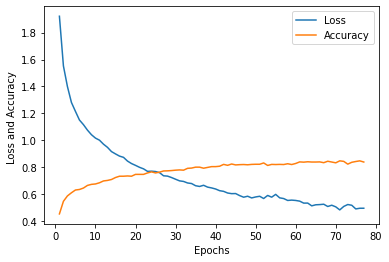

In [6]:
plt.plot(epoch_number, loss, label='Loss')
plt.plot(epoch_number, accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy ')
plt.legend()
plt.show()
#71st epoch with accuracy of 84.66

In [8]:
#Model2
import os
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
data_directory2 = "./Music-Generation-Using-Deep-Learning-master/Data2/"
data_file2 = "Test_result.txt"
charIndex_json2 = "char_to_index.json"
model_weights_directory2 = './Music-Generation-Using-Deep-Learning-master/Data2/Model_Weights_NoDropoutModifiedData/'
epochs=90
BATCH_SIZE = 16
SEQ_LENGTH = 64
file = open(os.path.join(data_directory2, data_file2), mode = 'r')
data2 = file.read()
file.close()
char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(data2))))}
print("Number of unique characters in our whole tunes database = {}".format(len(char_to_index))) #87

with open(os.path.join(data_directory2, charIndex_json2), mode = "w") as f:
    json.dump(char_to_index, f)
    
index_to_char = {i: ch for (ch, i) in char_to_index.items()}
unique_chars = len(char_to_index)

#MOdel
model = Sequential()
   
model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (BATCH_SIZE, SEQ_LENGTH), name = "embd_1")) 

model.add(LSTM(256, return_sequences = True, stateful = True, name = "lstm_first"))
#model.add(Dropout(0.2, name = "drp_1"))

model.add(LSTM(256, return_sequences = True, stateful = True))
#model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(unique_chars)))
model.add(Activation("softmax"))

model.load_weights("./Music-Generation-Using-Deep-Learning-master/Data/Model_Weights_NoDropoutModifiedData/Weights_{}.h5".format(71), by_name = True)

adam=Adam(learning_rate=0.001,clipnorm=1,name='adam')
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

all_characters = np.asarray([char_to_index[c] for c in data2], dtype = np.int32)
print("Total number of characters = "+str(all_characters.shape[0])) #155222

epoch_number, loss, accuracy = [], [], []
max_checks_without_progress = 5
checks_without_progress = 0
best_loss = np.infty
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    final_epoch_loss, final_epoch_accuracy = 0, 0
    epoch_number.append(epoch+1)
    
    for i, (x, y) in enumerate(read_batches(all_characters, unique_chars)):
        final_epoch_loss, final_epoch_accuracy = model.train_on_batch(x, y) 
    loss.append(final_epoch_loss)
    accuracy.append(final_epoch_accuracy)
    print("Loss: {}, Accuracy: {}".format(final_epoch_loss, final_epoch_accuracy))
    if loss[epoch] < best_loss:
      best_loss = loss[epoch]
      best_weight2=epoch
      check_without_progress = 0
    else:
      check_without_progress +=1
      print('Count for stopping {}'.format(check_without_progress))
      if check_without_progress > max_checks_without_progress:
        model.save_weights(os.path.join(model_weights_directory2, "Weights_{}.h5".format(best_weight2+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(best_weight2+1, best_weight2+1))
        print("Early stopping!")
        break 
    #saving weights after every 10 epochs
    if (epoch + 1) % 10 == 0:
        if not os.path.exists(model_weights_directory2):
            os.makedirs(model_weights_directory2)
        model.save_weights(os.path.join(model_weights_directory2, "Weights_{}.h5".format(epoch+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(epoch+1, epoch+1))

#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Loss", "Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Loss"] = loss
log_frame["Accuracy"] = accuracy
log_frame.to_csv("./Music-Generation-Using-Deep-Learning-master/Data2/log_NoDropoutModifiedData.csv", index = False)


Number of unique characters in our whole tunes database = 87
Total number of characters = 500562
Epoch 1/90
Loss: 1.8191195726394653, Accuracy: 0.4541015625
Epoch 2/90
Loss: 1.389769196510315, Accuracy: 0.5869140625
Epoch 3/90
Loss: 1.198771595954895, Accuracy: 0.6201171875
Epoch 4/90
Loss: 1.1001883745193481, Accuracy: 0.67578125
Epoch 5/90
Loss: 1.0405805110931396, Accuracy: 0.689453125
Epoch 6/90
Loss: 0.9635986089706421, Accuracy: 0.70703125
Epoch 7/90
Loss: 0.9282324910163879, Accuracy: 0.7138671875
Epoch 8/90
Loss: 0.8839715719223022, Accuracy: 0.7236328125
Epoch 9/90
Loss: 0.8289939761161804, Accuracy: 0.7333984375
Epoch 10/90
Loss: 0.787973165512085, Accuracy: 0.7568359375
Saved Weights at epoch 10 to file Weights_10.h5
Epoch 11/90
Loss: 0.7310388684272766, Accuracy: 0.765625
Epoch 12/90
Loss: 0.6853943467140198, Accuracy: 0.7890625
Epoch 13/90
Loss: 0.64584881067276, Accuracy: 0.791015625
Epoch 14/90
Loss: 0.6206010580062866, Accuracy: 0.7998046875
Epoch 15/90
Loss: 0.58279204

57


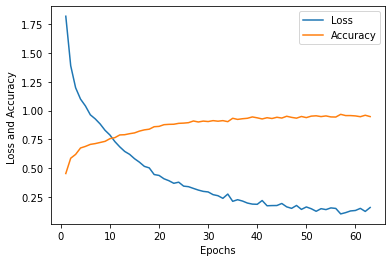

In [10]:
print(best_weight2+1)
plt.plot(epoch_number, loss, label='Loss')
plt.plot(epoch_number, accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy ')
plt.legend()
plt.show()
#57th with accuracy of 96.77

## Music Generation Cell
A block to generate Music loading the previously stored weights.

In [1]:
#Music Generation
import os
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import matplotlib.pyplot as plt
data_directory = "./Music-Generation-Using-Deep-Learning-master/Data2/"
charIndex_json = "char_to_index.json"
model_weights_directory2 = './Music-Generation-Using-Deep-Learning-master/Data2/Model_Weights_NoDropoutModifiedData/'
BATCH_SIZE = 16
SEQ_LENGTH = 64

#ep = int(input("1. Which epoch number weight you want to load into the model(10, 20, 30, ..., 90). Small number will generate more errors in music: "))
ar = int(input("\n1. Enter any number between 0 to 86 which will be given as initial charcter to model for generating sequence: "))
ln = int(input("\n2. Enter the length of music sequence you want to generate. Typical number is between 300-600. Too small number will generate hardly generate any sequence: "))

with open(os.path.join(data_directory, charIndex_json)) as f:
    char_to_index = json.load(f)
index_to_char = {i:ch for ch, i in char_to_index.items()}
unique_chars = len(index_to_char)

model = Sequential()

model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (1,1))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))
model.add(LSTM(256,  stateful = True))
#I haven't given return_sequences = True because here I will give only one character to generate the
#sequence. In the end, I just have to get one output which is equivalent to getting output at the last time-stamp. So, here
#in last layer there is no need of giving return sequences = True.
model.add(Dropout(0.2))

model.add(Dense(unique_chars))
model.add(Activation("softmax"))
#model.summary()
model.load_weights(model_weights_directory2 + "Weights_{}.h5".format(57))
  
sequence_index = [ar]

for _ in range(ln):
    batch = np.zeros((1, 1))
    batch[0, 0] = sequence_index[-1]
    
    predicted_probs = model.predict_on_batch(batch).ravel()
    sample = np.random.choice(range(unique_chars), size = 1, p = predicted_probs)
    
    sequence_index.append(sample[0])

seq = ''.join(index_to_char[c] for c in sequence_index)

cnt = 0
for i in seq:
    cnt += 1
    if i == "\n":
        break
seq1 = seq[cnt:]
#above code is for ignoring the starting string of a generated sequence. This is because we are passing any arbitrary 
#character to the model for generating music. Now, the model start generating sequence from that character itself which we 
#have passed, so first few characters before "\n" contains meaningless word. Model start generating the music rhythm from
#next line onwards. The correct sequence it start generating from next line onwards which we are considering.

print('########################################################')
print(seq1)




Using TensorFlow backend.



1. Enter any number between 0 to 86 which will be given as initial charcter to model for generating sequence: 30

2. Enter the length of music sequence you want to generate. Typical number is between 300-600. Too small number will generate hardly generate any sequence: 1000
########################################################
d>e (3.d.d.d g>efd |g2de f2fd |e>d (3.d.d.d cdAF | Geee fe"D.C."dB |]


M:C|
L:1/8
R:Reel
K:A
ge|dcBcA2(cd)|edcA BGEF|G2(BG) ABcA|BdcA GEDE|
A2(ag) eAAf|eagea2(ef)|ecBcA2(Bc)|
dBde faef|agfe defg|abag fedB|1ABcd efge||
aedeg2(ag)|eaag (ef)af|eaaf egfa|1edBd cAFA||
(3BcB (dB) cAFA| BABd edef|ecBcA2(ce)|ea{b}ag ef"D."e|]


R:Reel
M:C|
L:1/8
K:D
F3D FEFG|A2(AB) cBcA|d2(dc) BAGF|EFGE (FD)D2|
d2(ed) cAGB|ABcA dBcA|A2(AG) FGAc|AFGE DAdc|
dedc dfec|dcde fdeg|(3fgf df ecAG|FGAF FDD2||
fdfd gdfd|cdef gedc|d2(dc) dAFA|faec (d" Hegno"eind"ei)|]


R:Reel
M:C|
L:1/8
K:G
DEGc dGBG|ABcA ED DzG|DGBG AGEG|AcBA GE E||
cBAc BGGF|EAAG FGAF|GBGB dBAG|FAdc d2:|
|:de|dBGBd2ga|gbge 